In [1]:
import os
import sys
from itertools import product

import numpy as np
import pandas as pd

from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, make_scorer, accuracy_score

import matplotlib.pyplot as plt
plt.style.use('dark_background')
import seaborn as sns

%matplotlib inline

lengths = lambda x, i: [len(g) for _, g in x.groupby(['EventNumber'])][i]
view = lambda x, i: [g for _, g in x.groupby(['EventNumber'])][i]


/home/isaac/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [2]:
#Set for your computer
data_directory = '/'.join(os.getcwd().split("/")[:-2]) + '/data/'

In [3]:
test_set = [173,  74,  20, 101,  83,   1,  38,  39,  72,  50,  21, 164,  57,
       169, 8,  63, 102,  34,  80, 192, 139,  88, 112, 116,  61,  46,
        51, 165, 135,  89, 108,   7,  25,  15, 125,  93, 130,  71]

In [29]:
orig_data = pd.read_csv(data_directory + 'qaData.csv', parse_dates=['Date'])
orig_data['EarningTag2'] = orig_data['EarningTag2'].str.strip()

#Add Year and Month, Quarter from Data
orig_data['Year'] = orig_data['Date'].dt.year
orig_data['Month'] = orig_data['Date'].dt.month
orig_data['Quarter'] = orig_data['Month'].apply(lambda x: 1 if x < 4 else 2 if x < 7 else 3 if x < 9 else 4)
orig_data['Company'] = orig_data['Company'].str.title().str.replace(" ", "")
orig_data['EventType'] = orig_data['EventType'].str.title().str.replace(" ", "")
orig_data['Participants'] = orig_data['Participants'].str.title().str.replace(" ", "")
orig_data['AnalystName'] = orig_data['AnalystName'].str.title().str.replace(" ", "")
orig_data['AnalystCompany'] = orig_data['AnalystCompany'].str.title().str.replace(" ", "")
orig_data['Tag'] = orig_data['EarningTag2'].str.title().str.replace(" ", "")

orig_data = orig_data.loc[~orig_data['AnalystName'].isna()].copy()

tag_cols = orig_data['Tag'].unique().tolist()

#Index Data
groups = []
for i, (name, group) in enumerate(orig_data.groupby(['Company', 'Participants', 'Month', 'Year', 'Quarter', 'EventType', 'Date'])):
    g2 = group.copy()
    g2['EventNumber'] = i
    groups.append(g2)
    
indexed_data = pd.concat(groups)[['EventNumber','Company', 'Month', 'Year', 'Quarter', 'EventType', 'Date', 'AnalystName', "Tag"]]

analyst_data = pd.read_csv(data_directory+"analystTopic.csv")
indexed_data = indexed_data.merge(analyst_data, on=['AnalystName'])

tag_data = pd.read_csv(data_directory+"tagTopic.csv")
indexed_data = indexed_data.merge(tag_data, on=['Tag']).drop_duplicates()

company_data = pd.read_csv(data_directory+"companyTopic.csv")
indexed_data = indexed_data.merge(company_data, on=['Company']).drop_duplicates()


a_topic_cols = analyst_data.drop(['AnalystName', 'aTopicMax'], axis=1).columns.tolist()
topic_cols = a_topic_cols.copy()
t_topic_cols = tag_data.drop(['Tag', 'tTopicMax'], axis=1).columns.tolist()
topic_cols += t_topic_cols.copy()
c_topic_cols = company_data.drop(['Company', 'cTopicMax'], axis=1).columns.tolist()
topic_cols += c_topic_cols.copy()


In [30]:
cols_save = ['EventNumber','Company', 'Month', 'Year', 'Quarter', 'EventType', 'Date'] + a_topic_cols + t_topic_cols + c_topic_cols

pivot_data = pd.pivot_table(indexed_data, index=cols_save, columns=['tTopicMax'], aggfunc='size', fill_value=0)
pivot_data.columns = ["tTopicMax_"+pivot_data.columns]
pivot_data.reset_index(inplace=True)
pivot_data.columns = pivot_data.columns.get_level_values(0)

melt_data = pd.melt(pivot_data, id_vars=cols_save, var_name=['tTopicMax'], value_name='NumQ')
melt_data['NumQ'] = melt_data['NumQ'].astype(bool).astype(int)
melt_data['tTopicMax'] = melt_data['tTopicMax'].str.split("_").str[-1]
melt_data = pd.concat([melt_data,
                      pd.get_dummies(melt_data[['tTopicMax']])], axis=1).reset_index(drop=True)


features_data = melt_data.drop(['Company', 'EventType', 'Date', 'tTopicMax', 'Month', 'Year']+t_topic_cols, axis=1).drop_duplicates().copy()
train, test = features_data.loc[~features_data['EventNumber'].isin(test_set)].copy().reset_index(drop=True), \
                features_data.loc[features_data['EventNumber'].isin(test_set)].copy().reset_index(drop=True)

X_train, y_train = train.drop(['NumQ','EventNumber'], axis=1).values, train['NumQ'].values
X_test, y_test = test.drop(['NumQ', 'EventNumber'], axis=1).values, test['NumQ'].values

cols_list = train.drop(['NumQ','EventNumber'], axis=1).columns.values

In [31]:
features_data.head()

,EventNumber,Quarter,aTopic0,aTopic1,aTopic2,aTopic3,aTopic4,aTopic5,aTopic6,aTopic7,aTopic8,aTopic9,cTopic0,cTopic1,NumQ,tTopicMax_tTopic0,tTopicMax_tTopic1
0,0,2,0.000000,0.000000,0.000000,0.539259,0.333186,0.236236,0.390921,0.0,0.614790,0.107669,0.0,0.0,1,1,0
1,1,1,0.122445,0.000000,0.058339,0.925947,0.000000,0.000015,0.161762,0.0,0.313144,0.000365,0.0,0.0,1,1,0
2,1,1,0.122445,0.000000,0.058339,0.925947,0.000000,0.000015,0.161762,0.0,0.313144,0.000365,0.0,0.0,0,1,0
6,2,2,0.442518,0.595019,0.000000,0.554724,0.000000,0.000000,0.377375,0.0,0.000000,0.000000,0.0,0.0,1,1,0
7,2,2,0.442518,0.595019,0.000000,0.554724,0.000000,0.000000,0.377375,0.0,0.000000,0.000000,0.0,0.0,0,1,0


In [32]:
estimator = RandomForestClassifier(warm_start=True, n_estimators=1000).fit(X_train, y_train)
preds = estimator.predict_proba(X_test)[:,1]
print(roc_auc_score(y_test, preds))
print(accuracy_score(y_test, preds.round()))

0.5762270166861515
0.5587628865979382


In [34]:
estimator = GradientBoostingClassifier(warm_start=True, n_estimators=1000).fit(X_train, y_train)
preds = estimator.predict_proba(X_test)[:,1]
print(roc_auc_score(y_test, preds))
print(accuracy_score(y_test, preds.round()))

0.5853076841322138
0.554639175257732


In [10]:
importances = estimator.feature_importances_
std = np.std([tree.feature_importances_ for tree in estimator.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

for f in range(indices.shape[0]):
    
    print("{}. {} ({:.4f}|{:.4f}|{:.4f})".format(f+1, 
                                                 cols_list[indices[f]], 
                                                 importances[indices[f]]-std[indices[f]], 
                                                 importances[indices[f]],  
                                                 importances[indices[f]]+std[indices[f]] ))

1. Quarter (0.2260|0.2594|0.2927)
2. tTopicMax_tTopic1 (0.0372|0.1781|0.3190)
3. tTopicMax_tTopic0 (0.0313|0.1728|0.3143)
4. cTopic0 (0.0517|0.0683|0.0848)
5. cTopic1 (0.0515|0.0678|0.0841)
6. aTopic1 (0.0200|0.0319|0.0437)
7. aTopic6 (0.0169|0.0296|0.0423)
8. aTopic9 (0.0161|0.0294|0.0428)
9. aTopic8 (0.0161|0.0285|0.0409)
10. aTopic4 (0.0152|0.0250|0.0348)
11. aTopic0 (0.0153|0.0246|0.0340)
12. aTopic5 (0.0138|0.0222|0.0306)
13. aTopic7 (0.0133|0.0220|0.0307)
14. aTopic3 (0.0126|0.0203|0.0279)
15. aTopic2 (0.0122|0.0202|0.0282)


Text(0.5, 1.0, 'Feature Importances')

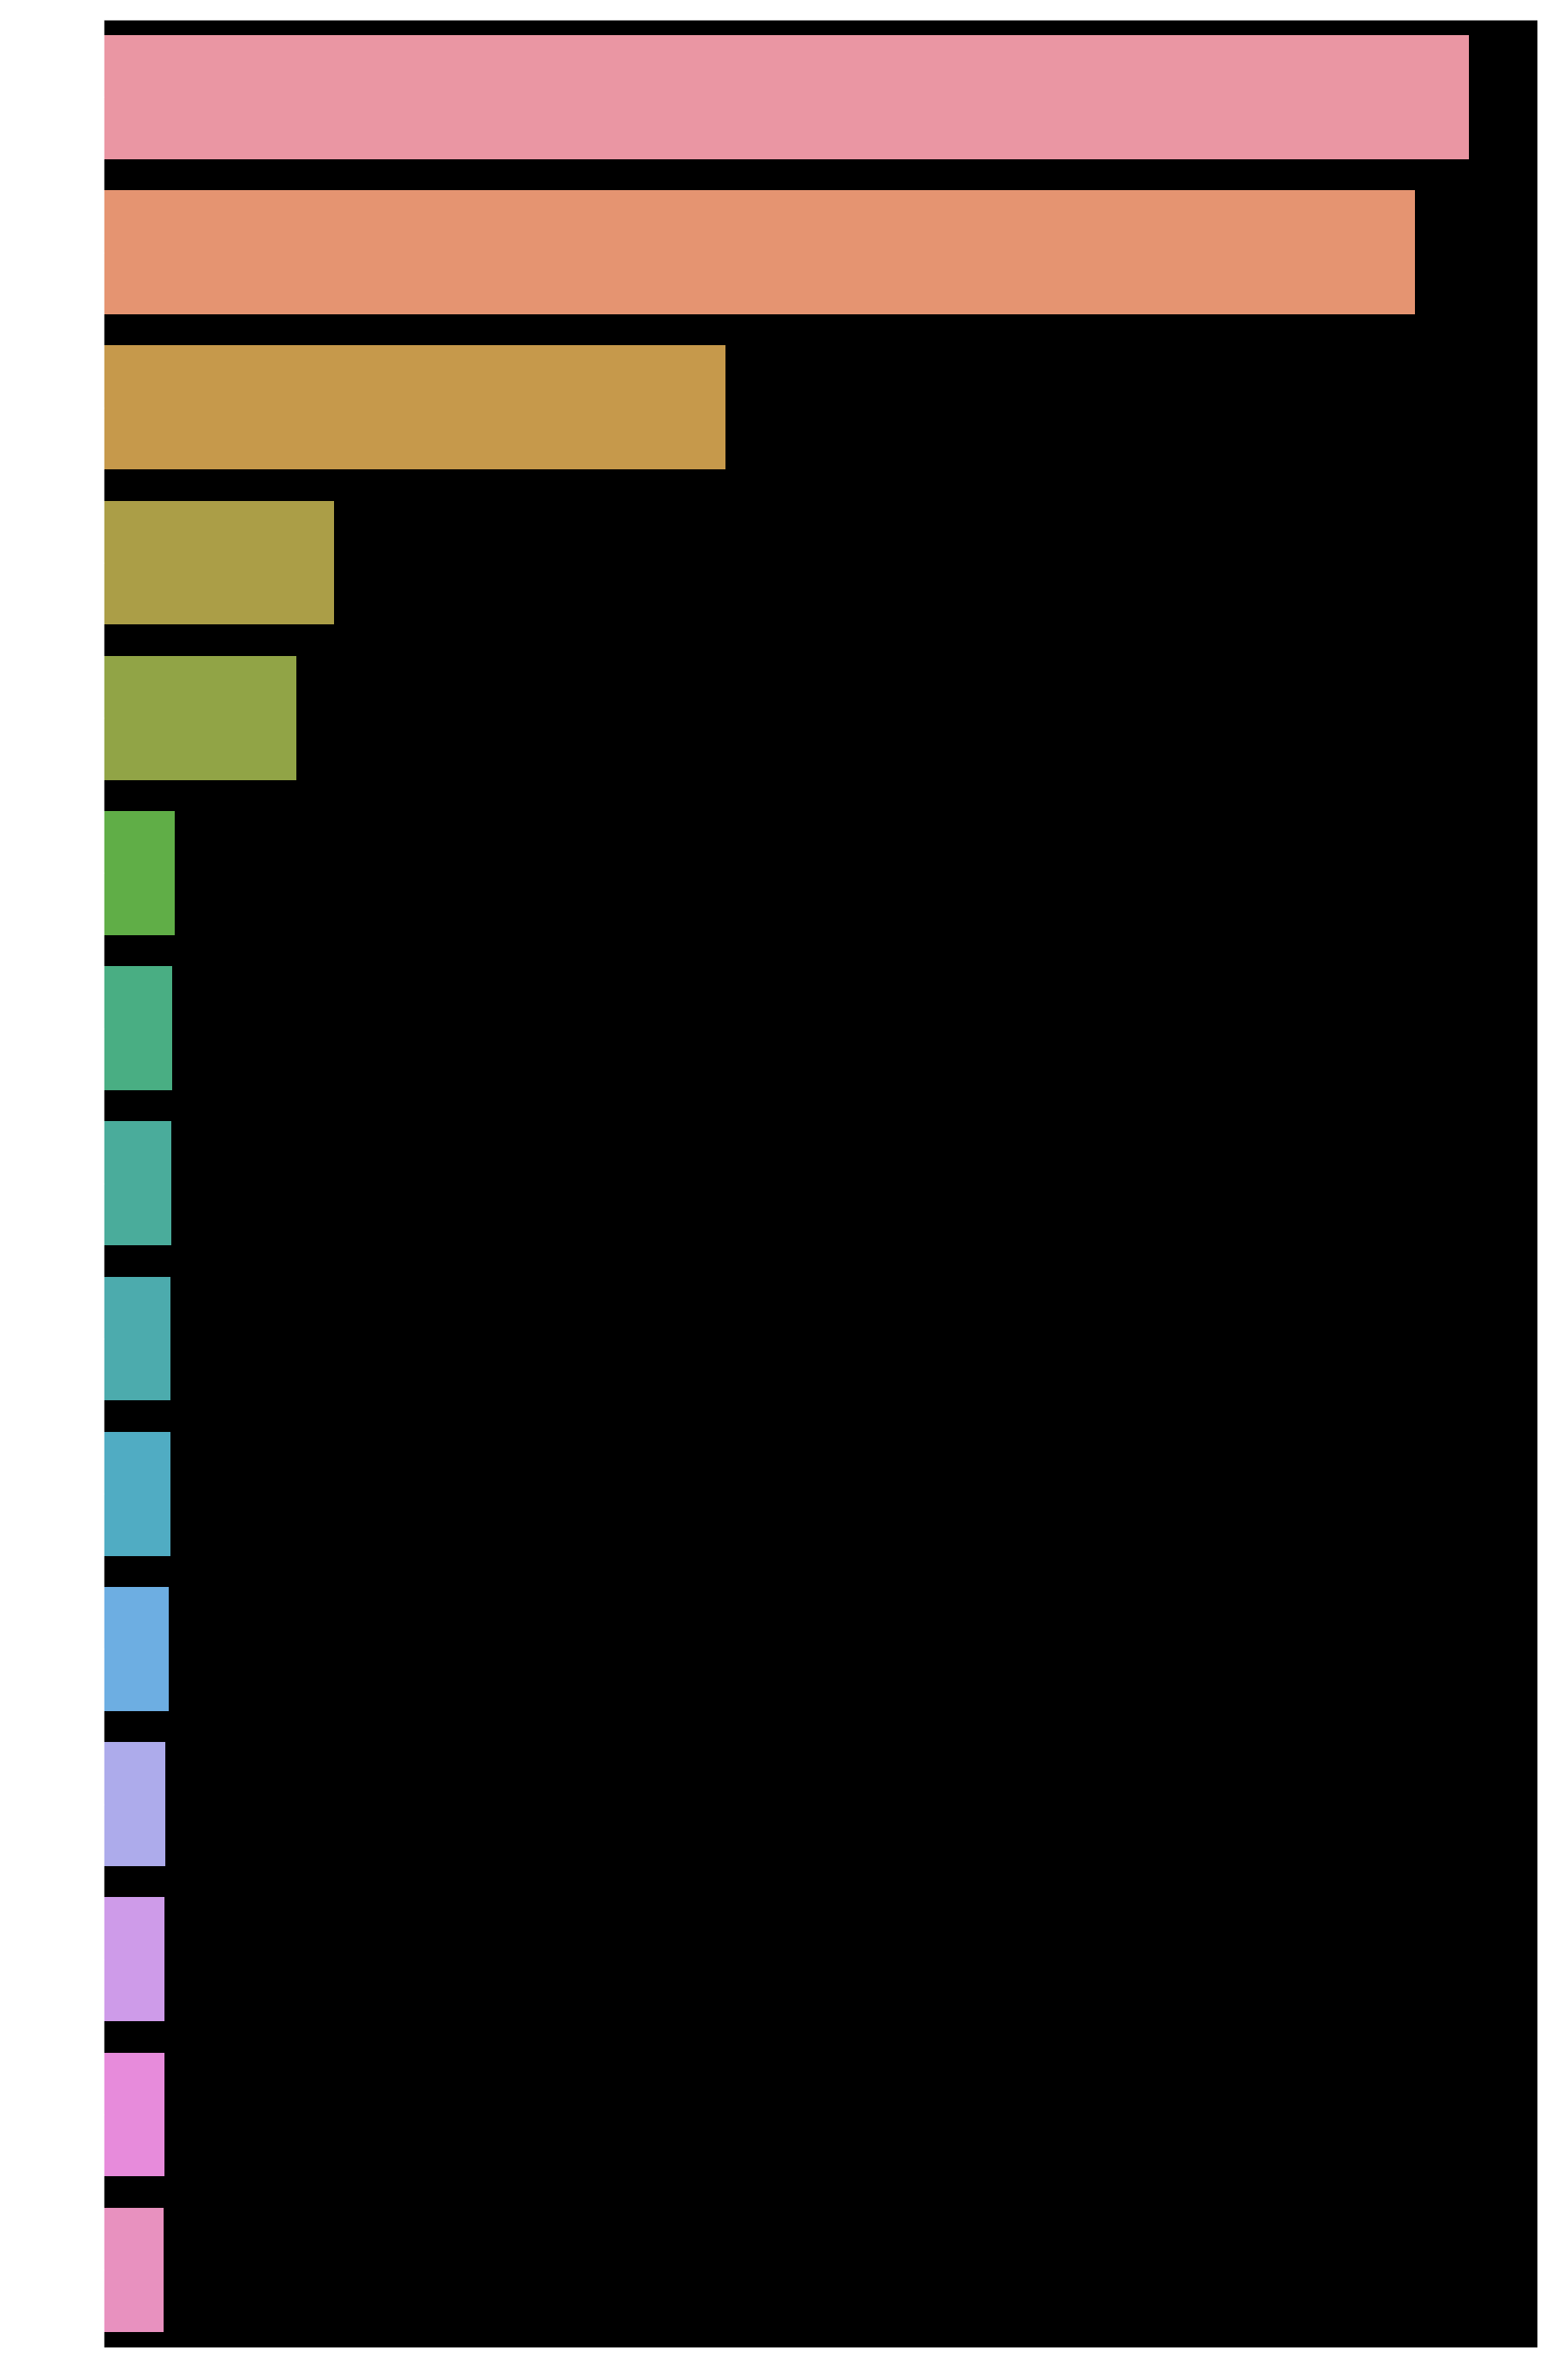

In [32]:
to_plot = pd.DataFrame({'features':cols_list[indices],
                        'importances':importances[indices],
                        'std':std[indices]})

fig = plt.figure(figsize=(30,50))
fig_plt = sns.barplot(data=to_plot, x='importances', y='features')
fig_plt.set_xlabel("Feature")
fig_plt.set_ylabel("Importance")
fig_plt.set_title('Feature Importances')